# Analytic Finite Element Method

This is a FEM implementation in a CAS and is intended to be useful
for understanding the implementation of the method.

The code solves the Navier-Cauchy equations for elasticity in 2D.

In [1]:
from sympy import *
init_session()

IPython console for SymPy 1.0 (Python 3.6.0-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.0/


In [2]:
def const_model(E, nu, const="plane_stress"):
    if const == "plane_stress":
        fac = E/(1 - nu**2)
        C = fac*Matrix([
            [1, nu, 0],
            [nu, 1, 0],
            [0, 0, (1 - nu)/2]])
    elif const == "plane_strain":
        fac = E*(1 - nu)/((1 - 2*nu)*(1 + nu))
        C = fac*Matrix([
            [1, nu/(1 - nu), 0],
            [nu/(1 - nu), 1, 0],
            [0, 0, (1 - 2*nu)/(2*(1 - nu))]])
    return C

In [3]:
r, s = symbols("r s")

## Interpolation functions and matrices

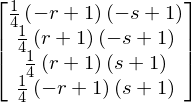

In [4]:
N = S(1)/4 *Matrix([
[(1 - r)*(1 - s)],
[(1 + r)*(1 - s)],
[(1 + r)*(1 + s)],
[(1 - r)*(1 + s)]])

display(N)

The interpolation matrix is a matrix with the interpolation
functions reordered for each degree of freedom.

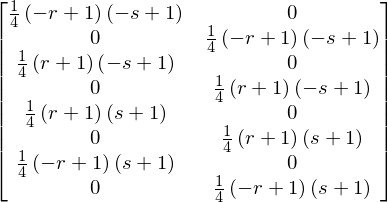

In [5]:
H = zeros(2, 8)
for cont in range(4):
    H[0, 2*cont] = N[cont]
    H[1, 2*cont + 1] = N[cont]

display(H.T)

The local derivatives matrix is formed with the derivatives of the interpolation functions

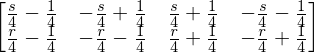

In [6]:
dHdr = zeros(2, 4)
for cont in range(4):
    dHdr[0, cont] = diff(N[cont], r)
    dHdr[1, cont] = diff(N[cont], s)

display(dHdr)

## Gauss integration

In [7]:
def gauss_int2d(f, x, y):
    acu = 0
    pts = [-1/sqrt(3), 1/sqrt(3)]
    w = [1, 1]
    for i in range(2):
        for j in range(2):
            acu += f.subs({x: pts[i], y: pts[j]})*w[i]*w[j]
    
    return acu

## Local matrices generation

The Jacobian of the transformation is given by the product of the derivative
matrix and the coordinates of each element

In [8]:
def jaco(dHdr, coord_el):
    return simplify(dHdr * coord_el)


def jaco_inv(dHdr, coord_el):
    jac = jaco(dHdr, coord_el)
    return Matrix([[jac[1, 1], -jac[0, 1]], [-jac[1, 0], jac[0, 0]]])/jac.det()

We can re-arrange the derivatives of the interpolation function as a matrix that
_translates_ from displacements to strains, commonly denoted by $B$

In [9]:
def B_mat(dHdr, coord_el):
    dHdx = jaco_inv(dHdr, coord_el) * dHdr
    B = zeros(3, 8)
    for cont in range(4):
        B[0, 2*cont] = dHdx[0, cont]
        B[1, 2*cont + 1] = dHdx[1, cont]
        B[2, 2*cont] = dHdx[1, cont]
        B[2, 2*cont + 1] = dHdx[0, cont]

    return simplify(B)

With these elements we can form the local stiffness and mass matrices.

In [10]:
def local_mass(H, coord_el, rho):
    det = jaco(dHdr, coord_el).det()
    integrand = rho * det * expand(H.T * H) 
    mass_mat = zeros(8, 8)
    for row in range(8):
        for col in range(row, 8):
            mass_mat[row, col] = gauss_int2d(integrand[row, col], r, s)
            mass_mat[col, row] = mass_mat[row, col]

    return mass_mat


def local_stiff(dHdr, coord_el, C):
    det = jaco(dHdr, coord_el).det()
    B = B_mat(dHdr, coord_el)
    integrand = det * expand(B.T * C * B)
    stiff_mat = zeros(8, 8)
    for row in range(8):
        for col in range(row, 8):
            stiff_mat[row, col] = gauss_int2d(integrand[row, col], r, s)
            stiff_mat[col, row] = stiff_mat[row, col]

    return stiff_mat

## Assembly process

In [11]:
def assembler(coords, elems, mat_props, const="plane_stress"):
    ncoords = coords.shape[0]
    stiff_glob = zeros(2*ncoords, 2*ncoords)
    mass_glob = zeros(2*ncoords, 2*ncoords)
    for el_cont, elem in enumerate(elems):
        E, nu, rho = mat_props[el_cont]
        C = const_model(E, nu, const=const)
        coord_el = coords[elem, :]
        stiff_loc = local_stiff(dHdr, coord_el, C)
        mass_loc = local_mass(H, coord_el, rho)
        for row in range(4):
            for col in range(4):
                row_glob = elem[row]
                col_glob = elem[col]
                # Stiffness matrix
                stiff_glob[2*row_glob, 2*col_glob] += stiff_loc[2*row, 2*col]
                stiff_glob[2*row_glob, 2*col_glob + 1] += stiff_loc[2*row, 2*col + 1]
                stiff_glob[2*row_glob + 1, 2*col_glob] += stiff_loc[2*row + 1, 2*col]
                stiff_glob[2*row_glob + 1, 2*col_glob + 1] += stiff_loc[2*row + 1, 2*col + 1]
                # Mass matrix
                mass_glob[2*row_glob, 2*col_glob] += mass_loc[2*row, 2*col]
                mass_glob[2*row_glob, 2*col_glob + 1] += mass_loc[2*row, 2*col + 1]
                mass_glob[2*row_glob + 1, 2*col_glob] += mass_loc[2*row + 1, 2*col]
                mass_glob[2*row_glob + 1, 2*col_glob + 1] += mass_loc[2*row + 1, 2*col + 1]

    return stiff_glob, mass_glob

## Example: Single element

In [12]:
coords = Matrix([
    [-1, -1],
    [1, -1],
    [1, 1],
    [-1, 1]])

elems = [[0, 1, 2, 3]]

mat_props = [[S(8)/3, S(1)/3, 1]] 

In [13]:
stiff, mass = assembler(coords, elems, mat_props, const="plane_strain")

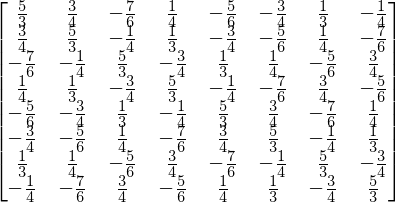

In [14]:
stiff

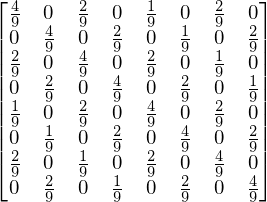

In [15]:
mass

## Example: $2 \times 2$ mesh

In [25]:
coords = Matrix([
        [-1, -1],
        [0, -1],
        [1, -1],
        [-1,  0],
        [0,  0],
        [1,  0],
        [-1,  1],
        [0,  1],
        [1,  1]])

elems = [[0, 1, 4, 3],
        [1, 2, 5, 4],
        [3, 4, 7, 6],
        [4, 5, 8, 7]]

mat_props = [[16, S(1)/3, 1]]*4

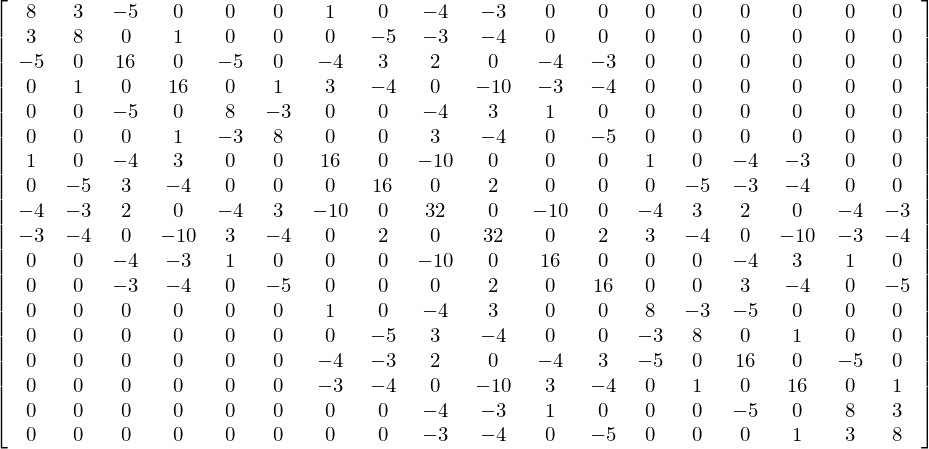

In [29]:
stiff, _ = assembler(coords, elems, mat_props)

In [28]:
stiff_exact = Matrix([
    [8, 3, -5, 0, 0, 0, 1, 0, -4, -3, 0, 0, 0, 0, 0, 0, 0, 0], 
    [3, 8, 0, 1, 0, 0, 0, -5, -3, -4, 0, 0, 0, 0, 0, 0, 0, 0], 
    [-5, 0, 16, 0, -5, 0, -4, 3, 2, 0, -4, -3, 0, 0, 0, 0, 0, 0], 
    [0, 1, 0, 16, 0, 1, 3, -4, 0, -10, -3, -4, 0, 0, 0, 0, 0, 0], 
    [0, 0, -5, 0, 8, -3, 0, 0, -4, 3, 1, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 1, -3, 8, 0, 0, 3, -4, 0, -5, 0, 0, 0, 0, 0, 0], 
    [1, 0, -4, 3, 0, 0, 16, 0, -10, 0, 0, 0, 1, 0, -4, -3, 0, 0], 
    [0, -5, 3, -4, 0, 0, 0, 16, 0, 2, 0, 0, 0, -5, -3, -4, 0, 0], 
    [-4, -3, 2, 0, -4, 3, -10, 0, 32, 0, -10, 0, -4, 3, 2, 0, -4, -3], 
    [-3, -4, 0, -10, 3, -4, 0, 2, 0, 32, 0, 2, 3, -4, 0, -10, -3, -4], 
    [0, 0, -4, -3, 1, 0, 0, 0, -10, 0, 16, 0, 0, 0, -4, 3, 1, 0], 
    [0, 0, -3, -4, 0, -5, 0, 0, 0, 2, 0, 16, 0, 0, 3, -4, 0, -5], 
    [0, 0, 0, 0, 0, 0, 1, 0, -4, 3, 0, 0, 8, -3, -5, 0, 0, 0], 
    [0, 0, 0, 0, 0, 0, 0, -5, 3, -4, 0, 0, -3, 8, 0, 1, 0, 0], 
    [0, 0, 0, 0, 0, 0, -4, -3, 2, 0, -4, 3, -5, 0, 16, 0, -5, 0], 
    [0, 0, 0, 0, 0, 0, -3, -4, 0, -10, 3, -4, 0, 1, 0, 16, 0, 1], 
    [0, 0, 0, 0, 0, 0, 0, 0, -4, -3, 1, 0, 0, 0, -5, 0, 8, 3], 
    [0, 0, 0, 0, 0, 0, 0, 0, -3, -4, 0, -5, 0, 0, 0, 1, 3, 8]])

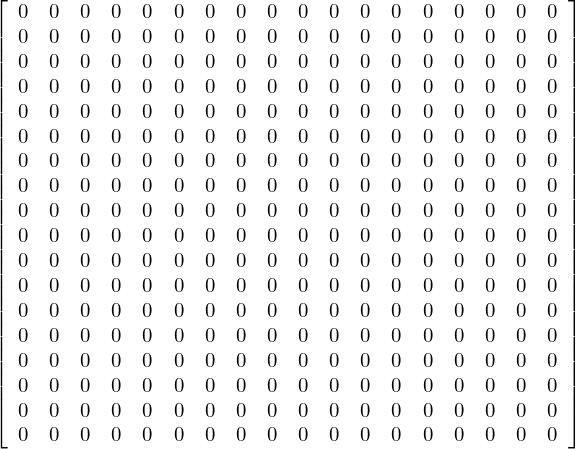

In [30]:
stiff_exact - stiff

In [31]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()